In [11]:
import torch
from torchvision import datasets, transforms
from torch import optim
from torch.autograd import Variable

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import time
import json
import os
from datetime import datetime

from vae import VAE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 128
data_dir = "../data/all-dogs/"
cropped_data_dir = "../data/all-dogs-cropped/"

def get_data_loader(path):

    random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply(random_transforms, p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    train_data = datasets.ImageFolder(path, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
    
    return train_loader
                                         
# imgs, label = next(iter(train_loader))
# imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [4]:
data_loader = get_data_loader(data_dir)
cropped_data_loader = get_data_loader(cropped_data_dir)

In [5]:
imgs, _ = next(iter(data_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

imgs_cropped, _ = next(iter(cropped_data_loader))
imgs_cropped = imgs_cropped.numpy().transpose(0, 2, 3, 1)

In [6]:
def train(model, train_loader, optimizer, epochs, imgs):
    
    mse_losses = []
    kld_losses = []
    
    model_save_path = "./checkpoints_/{}/".format(datetime.now())

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    for epoch in range(1, epochs+1):
        start_time = time.time()
        model.train()
        print('Starting epoch: {}'.format(epoch))

        mse_loss_total = 0
        kld_loss_total = 0

        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            mse_loss, kld_loss = model.loss_function(recon_batch, data, mu, logvar)

            mse_loss_total += mse_loss
            kld_loss_total += kld_loss

            loss = mse_loss + kld_loss

            loss.backward()
            optimizer.step()
            
        mse_losses.append(mse_loss_total)
        kld_losses.append(kld_loss_total)

        print("Loss: Total: {}, MSE: {}, KLD: {}".format(mse_loss_total+kld_loss_total, mse_loss_total, kld_loss_total))
        print('Time for epoch {}: {}'.format(epoch, time.time()-start_time))

        model.eval()
        recon_img, _, _ = model(torch.tensor(imgs[:1].transpose(0, 3, 1, 2)).to(device))
        img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)

        plt.imshow((img+1.)/2.)
        plt.show()
        
        torch.save(model.state_dict(), model_save_path + "epoch_{}.pth".format(epoch))
        
    return mse_losses, kld_losses

## Non cropped images

In [7]:
lr = 1e-3
epochs = 100
latent_dim = 64

model = VAE(latent_dim, batch_size=batch_size).to(device)

epoch_no = 100
model_load_path = "./checkpoints_/2023-04-13 21:27:03.269724/epoch_{}.pth".format(epoch_no)
model.load_state_dict(torch.load(model_load_path))

optimizer = optim.Adam(model.parameters(), lr=lr)

In [12]:
num_images = 1024
result_dir = "./results/test/"

samples = Variable(torch.randn(num_images, latent_dim, 4, 4)).to(device)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

for i, img in enumerate(samples):

    im = Image.fromarray((img * 255).astype(np.uint8))
    im.save(result_dir + "generated/{}.png".format(i))

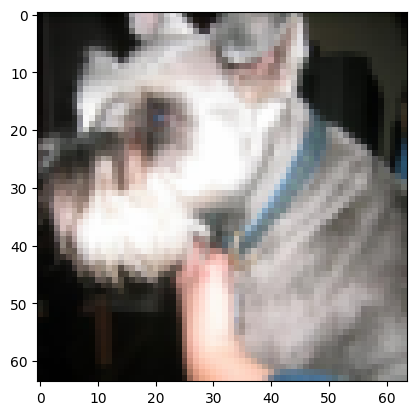

In [29]:
plt.imshow((imgs[0]+1)/2)
plt.show()

Starting epoch: 1
Loss: Total: 409.6103820800781, MSE: 404.1247863769531, KLD: 5.485594749450684
Time for epoch 1: 94.94974684715271


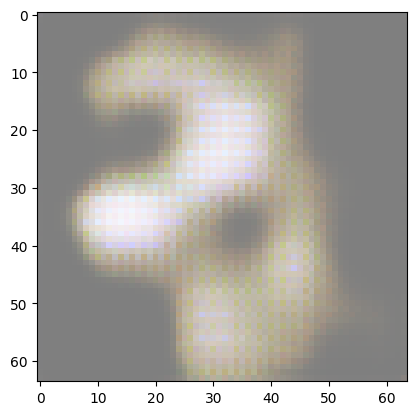

Starting epoch: 2
Loss: Total: 337.8523254394531, MSE: 333.7506103515625, KLD: 4.101711750030518
Time for epoch 2: 76.16374492645264


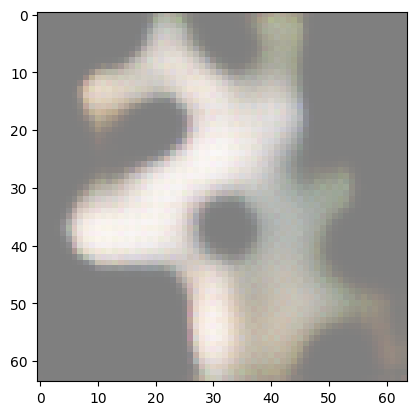

Starting epoch: 3
Loss: Total: 324.1854248046875, MSE: 319.8050537109375, KLD: 4.380361080169678
Time for epoch 3: 72.94067621231079


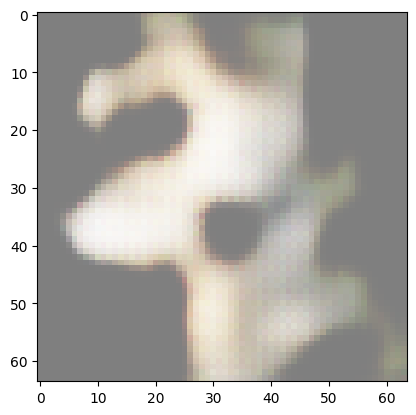

Starting epoch: 4
Loss: Total: 320.54168701171875, MSE: 316.0745849609375, KLD: 4.467111587524414
Time for epoch 4: 75.64767074584961


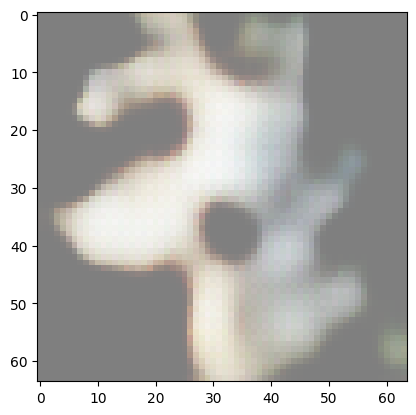

Starting epoch: 5
Loss: Total: 318.2120361328125, MSE: 313.71966552734375, KLD: 4.492372035980225
Time for epoch 5: 76.42599749565125


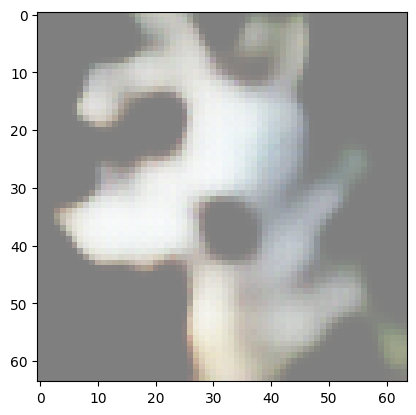

Starting epoch: 6
Loss: Total: 315.97882080078125, MSE: 311.4485168457031, KLD: 4.530311107635498
Time for epoch 6: 87.05821347236633


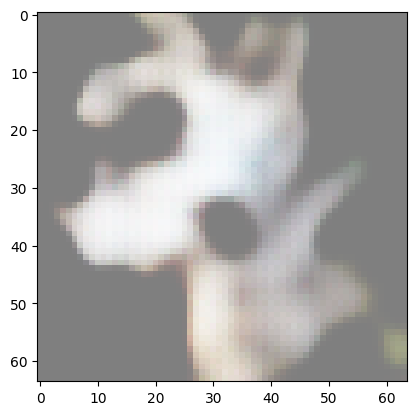

Starting epoch: 7
Loss: Total: 314.742431640625, MSE: 310.1179504394531, KLD: 4.624475479125977
Time for epoch 7: 106.25142669677734


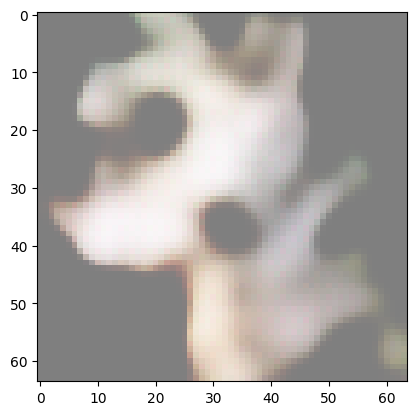

Starting epoch: 8
Loss: Total: 313.6510009765625, MSE: 308.9515380859375, KLD: 4.699469566345215
Time for epoch 8: 85.42642545700073


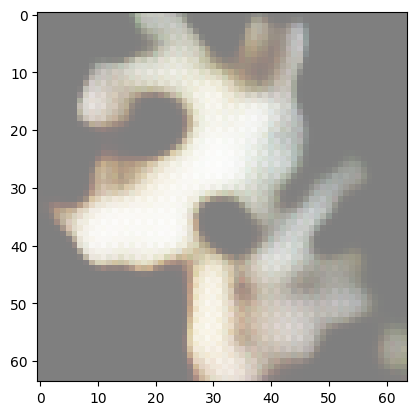

Starting epoch: 9
Loss: Total: 313.6087646484375, MSE: 308.8524169921875, KLD: 4.756356716156006
Time for epoch 9: 108.74545693397522


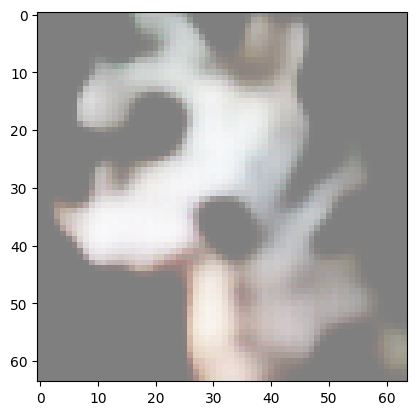

Starting epoch: 10
Loss: Total: 312.7362365722656, MSE: 307.9491882324219, KLD: 4.7870402336120605
Time for epoch 10: 140.09609842300415


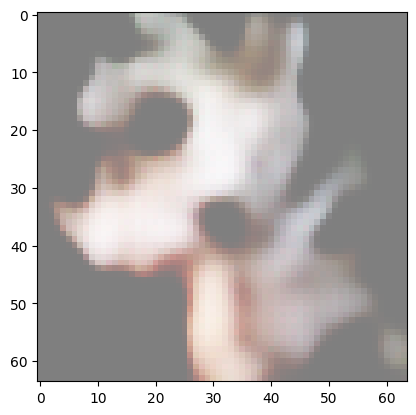

Starting epoch: 11
Loss: Total: 311.7008972167969, MSE: 306.88165283203125, KLD: 4.819240093231201
Time for epoch 11: 79.57887697219849


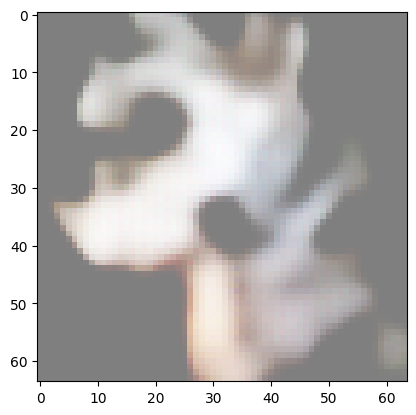

Starting epoch: 12
Loss: Total: 311.54058837890625, MSE: 306.6602783203125, KLD: 4.880302429199219
Time for epoch 12: 79.93171691894531


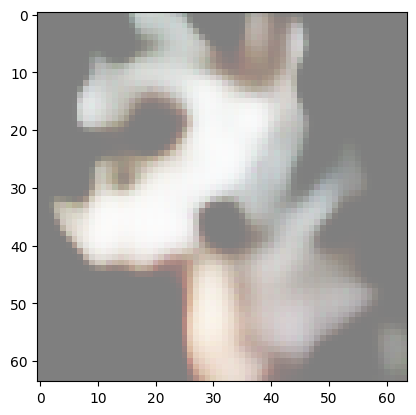

Starting epoch: 13
Loss: Total: 311.56072998046875, MSE: 306.6851806640625, KLD: 4.875561714172363
Time for epoch 13: 103.186767578125


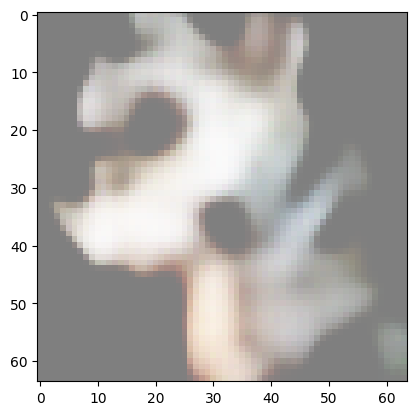

Starting epoch: 14
Loss: Total: 311.04046630859375, MSE: 306.1486511230469, KLD: 4.891824722290039
Time for epoch 14: 84.91946506500244


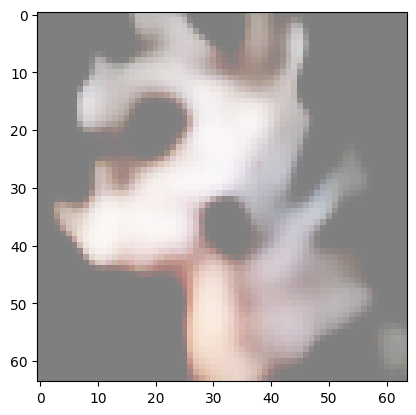

Starting epoch: 15
Loss: Total: 311.1903381347656, MSE: 306.2713928222656, KLD: 4.918955326080322
Time for epoch 15: 95.58511543273926


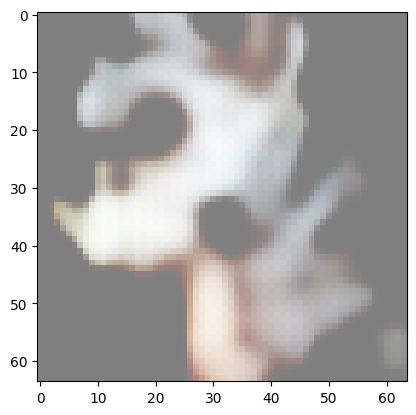

Starting epoch: 16
Loss: Total: 310.5838317871094, MSE: 305.6395263671875, KLD: 4.944295883178711
Time for epoch 16: 78.56768774986267


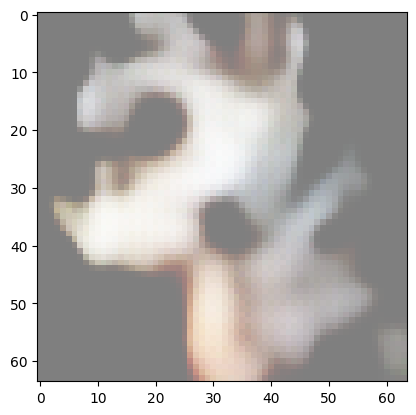

Starting epoch: 17
Loss: Total: 310.9936828613281, MSE: 306.0242004394531, KLD: 4.9694743156433105
Time for epoch 17: 73.89512228965759


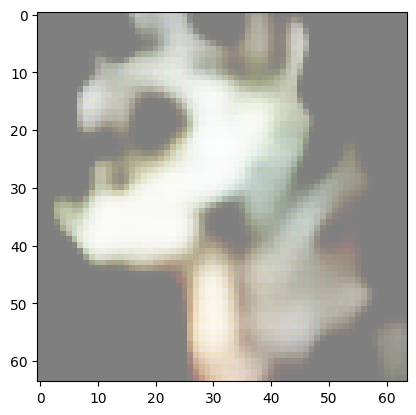

Starting epoch: 18
Loss: Total: 310.3874816894531, MSE: 305.3938903808594, KLD: 4.993603229522705
Time for epoch 18: 73.83475828170776


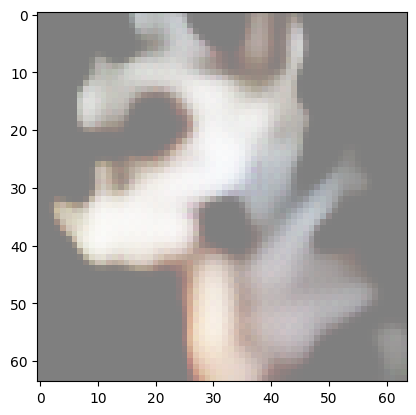

Starting epoch: 19
Loss: Total: 310.20733642578125, MSE: 305.2035217285156, KLD: 5.003812789916992
Time for epoch 19: 77.66950678825378


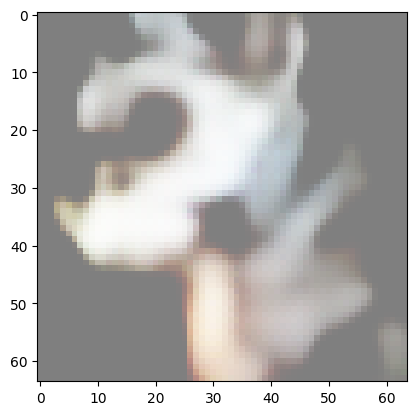

Starting epoch: 20
Loss: Total: 309.7318420410156, MSE: 304.7044677734375, KLD: 5.027371883392334
Time for epoch 20: 73.06275057792664


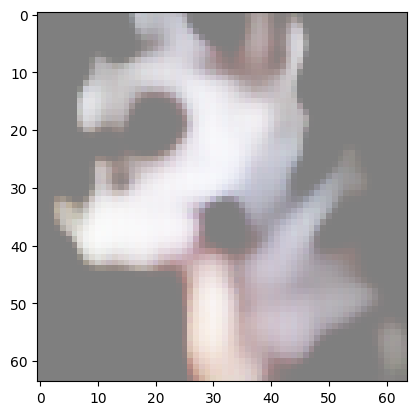

Starting epoch: 21
Loss: Total: 310.6275329589844, MSE: 305.5828857421875, KLD: 5.044647216796875
Time for epoch 21: 72.48164653778076


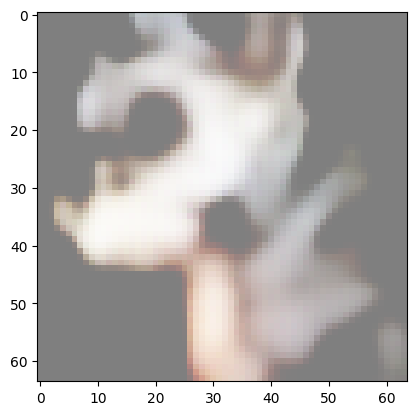

Starting epoch: 22
Loss: Total: 309.9129638671875, MSE: 304.86419677734375, KLD: 5.048768520355225
Time for epoch 22: 72.08749127388


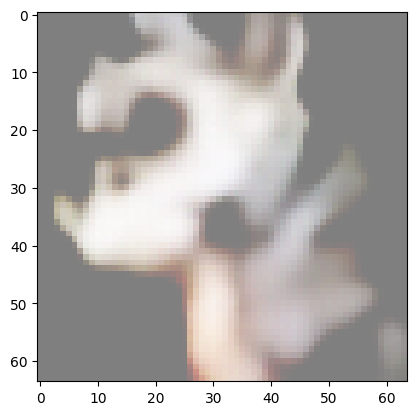

Starting epoch: 23
Loss: Total: 309.749755859375, MSE: 304.6649475097656, KLD: 5.084801197052002
Time for epoch 23: 71.22570967674255


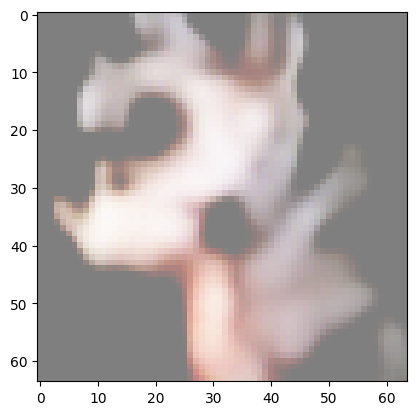

Starting epoch: 24
Loss: Total: 310.0594787597656, MSE: 304.9615478515625, KLD: 5.097917556762695
Time for epoch 24: 73.36092376708984


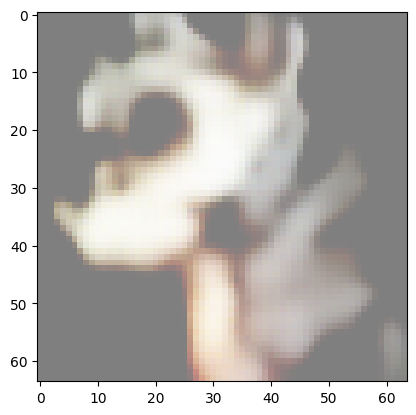

Starting epoch: 25
Loss: Total: 310.05255126953125, MSE: 304.9310607910156, KLD: 5.121501922607422
Time for epoch 25: 91.44896483421326


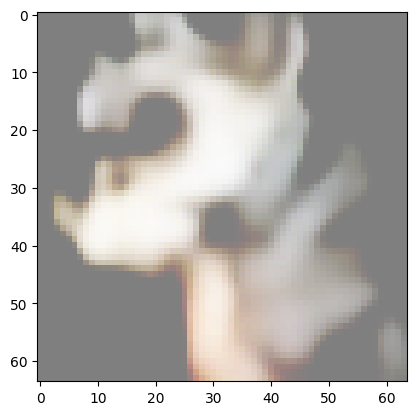

Starting epoch: 26
Loss: Total: 309.47894287109375, MSE: 304.33599853515625, KLD: 5.142942428588867
Time for epoch 26: 80.46416521072388


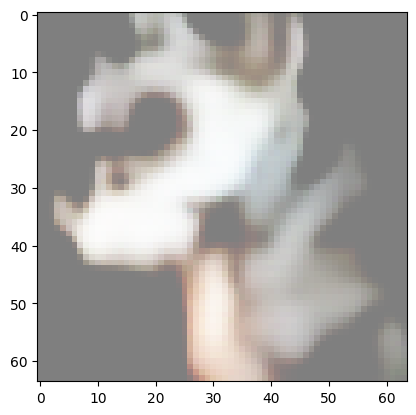

Starting epoch: 27
Loss: Total: 309.91094970703125, MSE: 304.7470703125, KLD: 5.16389274597168
Time for epoch 27: 86.09070754051208


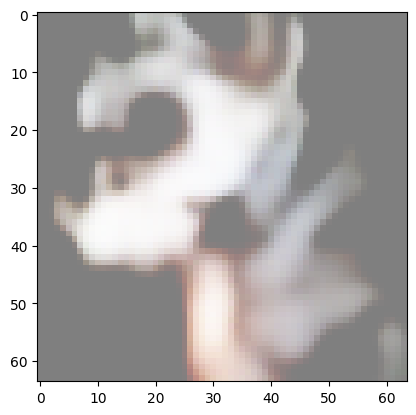

Starting epoch: 28
Loss: Total: 309.9255676269531, MSE: 304.7607421875, KLD: 5.164832592010498
Time for epoch 28: 87.07771682739258


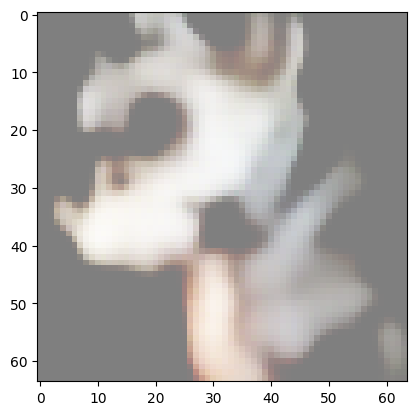

Starting epoch: 29
Loss: Total: 309.45526123046875, MSE: 304.2720947265625, KLD: 5.183178901672363
Time for epoch 29: 94.33949851989746


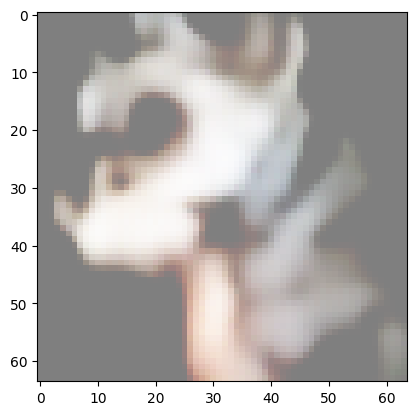

Starting epoch: 30
Loss: Total: 308.8509521484375, MSE: 303.67669677734375, KLD: 5.174261093139648
Time for epoch 30: 93.18707585334778


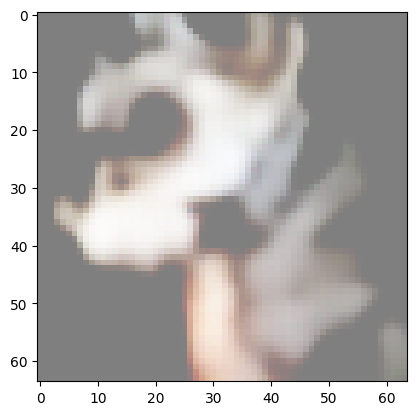

Starting epoch: 31
Loss: Total: 309.0494079589844, MSE: 303.869384765625, KLD: 5.18003511428833
Time for epoch 31: 91.47810792922974


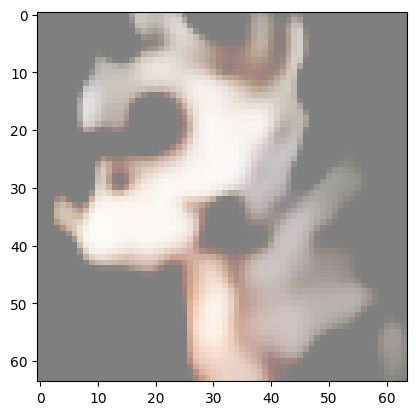

Starting epoch: 32
Loss: Total: 309.5868835449219, MSE: 304.3869323730469, KLD: 5.1999382972717285
Time for epoch 32: 87.08335590362549


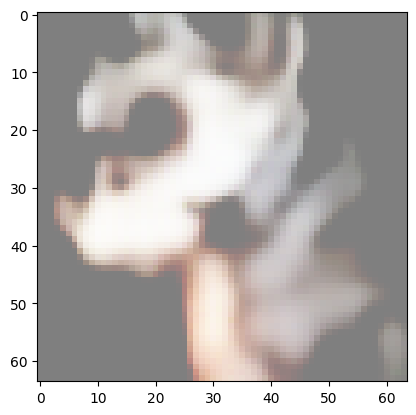

Starting epoch: 33
Loss: Total: 309.63348388671875, MSE: 304.4337463378906, KLD: 5.199728965759277
Time for epoch 33: 85.36589813232422


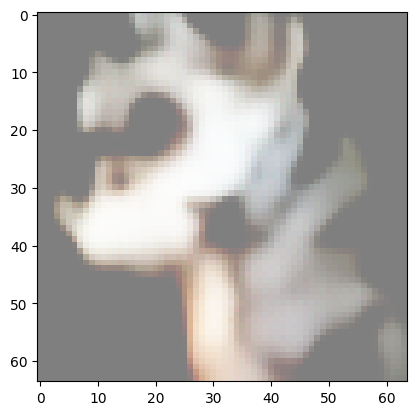

Starting epoch: 34
Loss: Total: 309.302490234375, MSE: 304.087646484375, KLD: 5.214840888977051
Time for epoch 34: 81.1020393371582


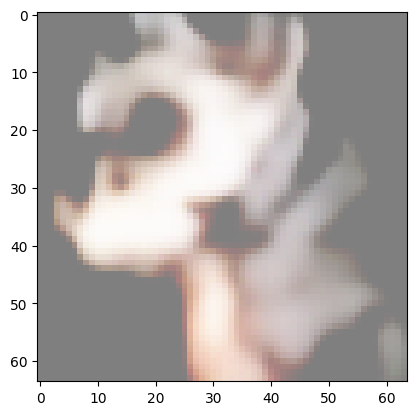

Starting epoch: 35
Loss: Total: 309.1976318359375, MSE: 303.9927062988281, KLD: 5.204925537109375
Time for epoch 35: 176.91790676116943


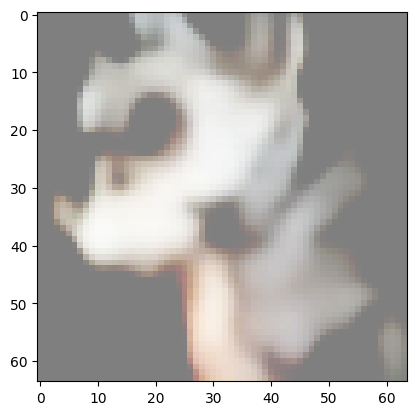

Starting epoch: 36
Loss: Total: 308.986328125, MSE: 303.7725830078125, KLD: 5.213759422302246
Time for epoch 36: 92.24166059494019


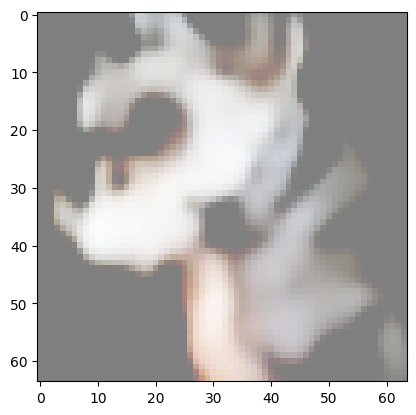

Starting epoch: 37
Loss: Total: 309.0340270996094, MSE: 303.803466796875, KLD: 5.230546474456787
Time for epoch 37: 75.16665410995483


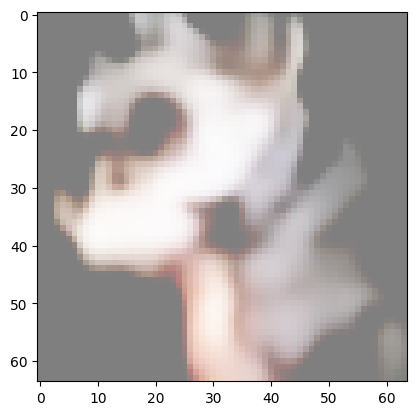

Starting epoch: 38
Loss: Total: 309.01043701171875, MSE: 303.75640869140625, KLD: 5.254040241241455
Time for epoch 38: 74.99996662139893


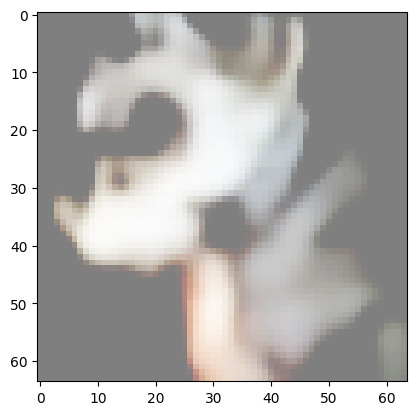

Starting epoch: 39
Loss: Total: 308.8432922363281, MSE: 303.5749816894531, KLD: 5.268295764923096
Time for epoch 39: 74.17698359489441


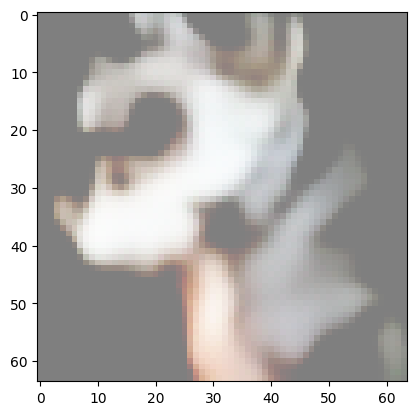

Starting epoch: 40
Loss: Total: 308.49298095703125, MSE: 303.22918701171875, KLD: 5.263779640197754
Time for epoch 40: 74.16492748260498


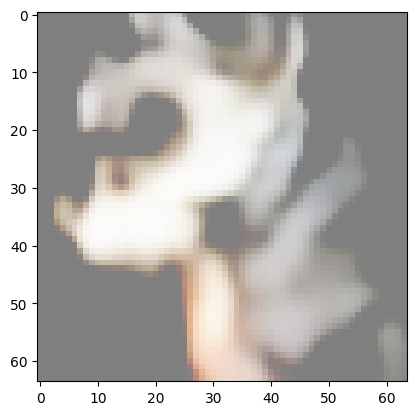

Starting epoch: 41
Loss: Total: 308.4096374511719, MSE: 303.120849609375, KLD: 5.288785934448242
Time for epoch 41: 72.42411136627197


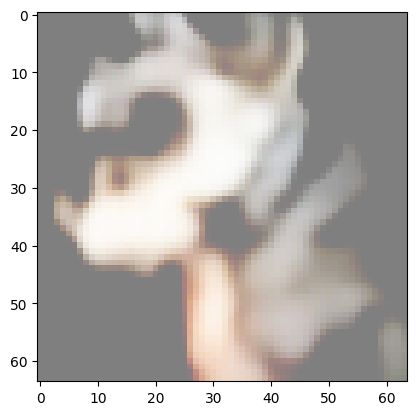

Starting epoch: 42
Loss: Total: 308.9390869140625, MSE: 303.64874267578125, KLD: 5.290350437164307
Time for epoch 42: 71.11370062828064


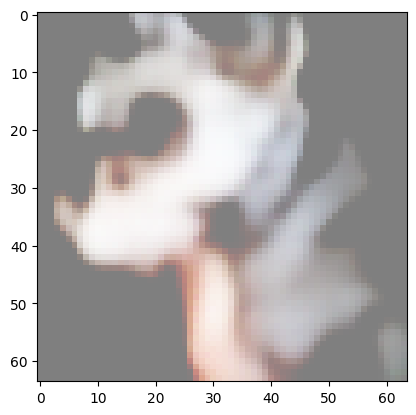

Starting epoch: 43
Loss: Total: 309.1006164550781, MSE: 303.7944641113281, KLD: 5.306149959564209
Time for epoch 43: 73.57285618782043


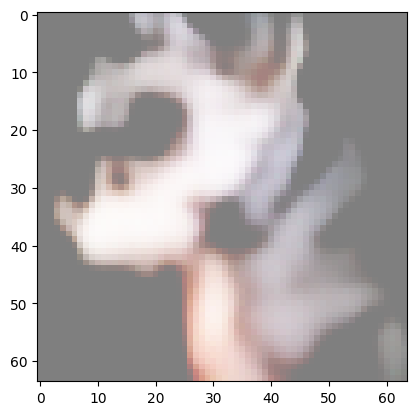

Starting epoch: 44
Loss: Total: 307.9862060546875, MSE: 302.6764831542969, KLD: 5.309731483459473
Time for epoch 44: 70.81545853614807


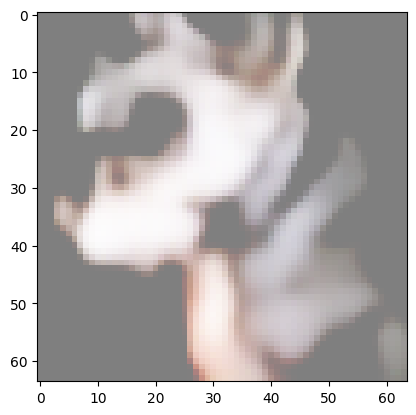

Starting epoch: 45
Loss: Total: 308.46270751953125, MSE: 303.1293029785156, KLD: 5.333393573760986
Time for epoch 45: 72.48862385749817


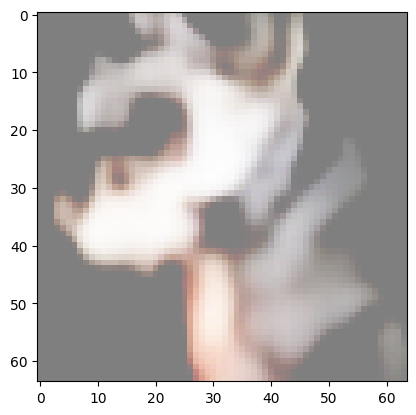

Starting epoch: 46
Loss: Total: 308.99945068359375, MSE: 303.6589050292969, KLD: 5.340554714202881
Time for epoch 46: 73.20171976089478


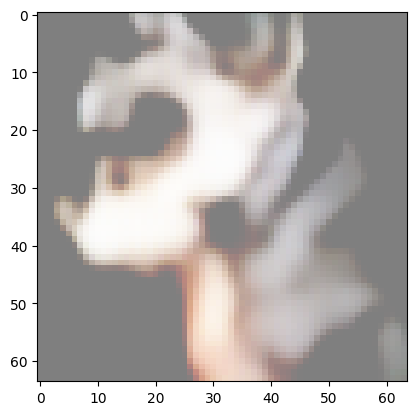

Starting epoch: 47
Loss: Total: 308.9089050292969, MSE: 303.5726013183594, KLD: 5.336304664611816
Time for epoch 47: 78.84144449234009


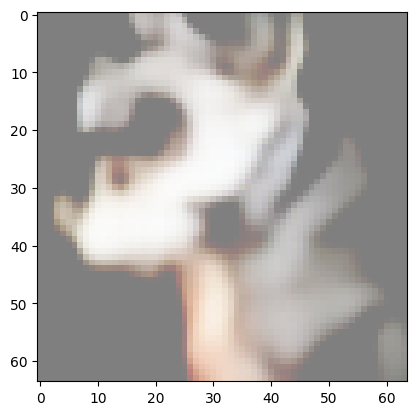

Starting epoch: 48
Loss: Total: 308.62896728515625, MSE: 303.2822265625, KLD: 5.346755504608154
Time for epoch 48: 81.57469248771667


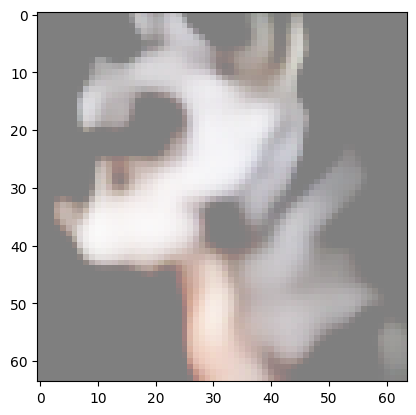

Starting epoch: 49
Loss: Total: 308.4429626464844, MSE: 303.0930480957031, KLD: 5.349917411804199
Time for epoch 49: 78.69083738327026


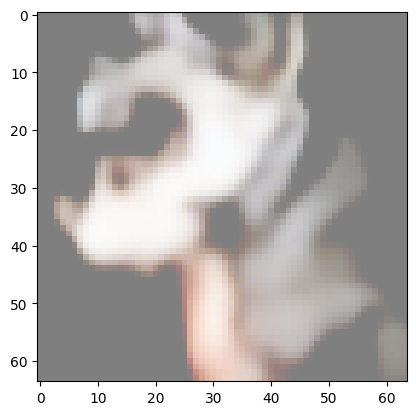

Starting epoch: 50
Loss: Total: 308.6607360839844, MSE: 303.30401611328125, KLD: 5.356724262237549
Time for epoch 50: 75.75824570655823


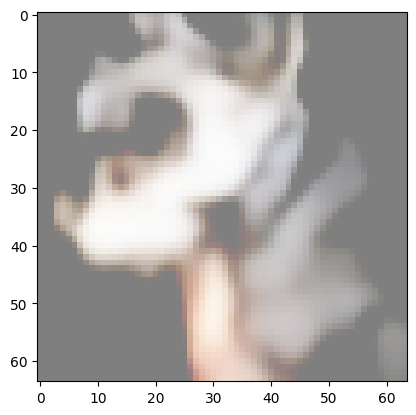

Starting epoch: 51
Loss: Total: 308.24456787109375, MSE: 302.89129638671875, KLD: 5.353275775909424
Time for epoch 51: 83.76301455497742


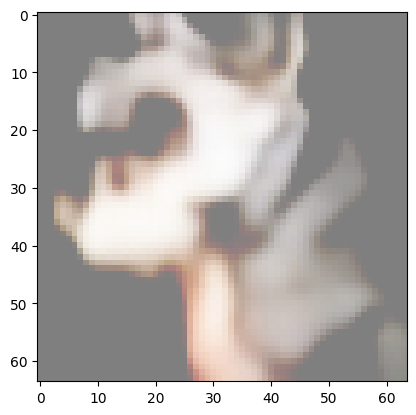

Starting epoch: 52


In [ ]:
mse_losses, kld_losses = train(model, data_loader, optimizer, epochs, imgs)

In [11]:
mse_losses = torch.tensor(mse_losses, device = 'cpu').numpy()
kld_losses = torch.tensor(kld_losses, device = 'cpu').numpy()

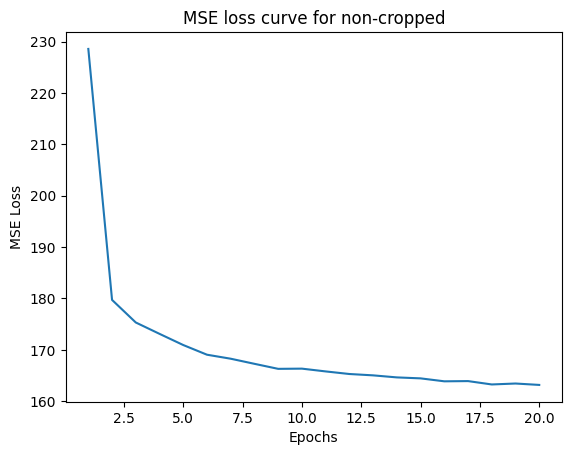

In [12]:
plt.plot(list(range(1, len(mse_losses)+1)), mse_losses)
plt.title('MSE loss curve for non-cropped')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

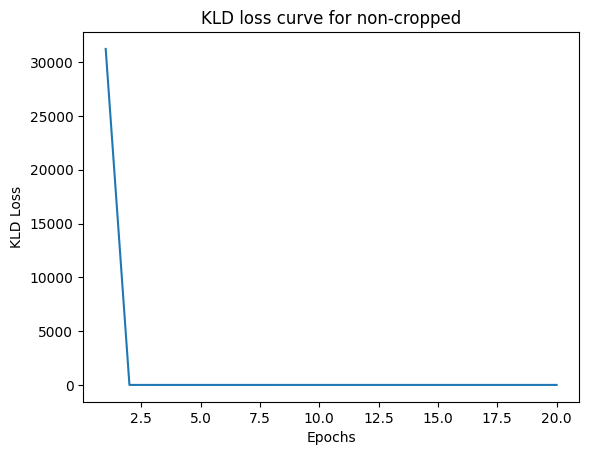

In [13]:
plt.plot(list(range(1, len(kld_losses)+1)), kld_losses)
plt.title('KLD loss curve for non-cropped')
plt.xlabel('Epochs')
plt.ylabel('KLD Loss')
plt.show()

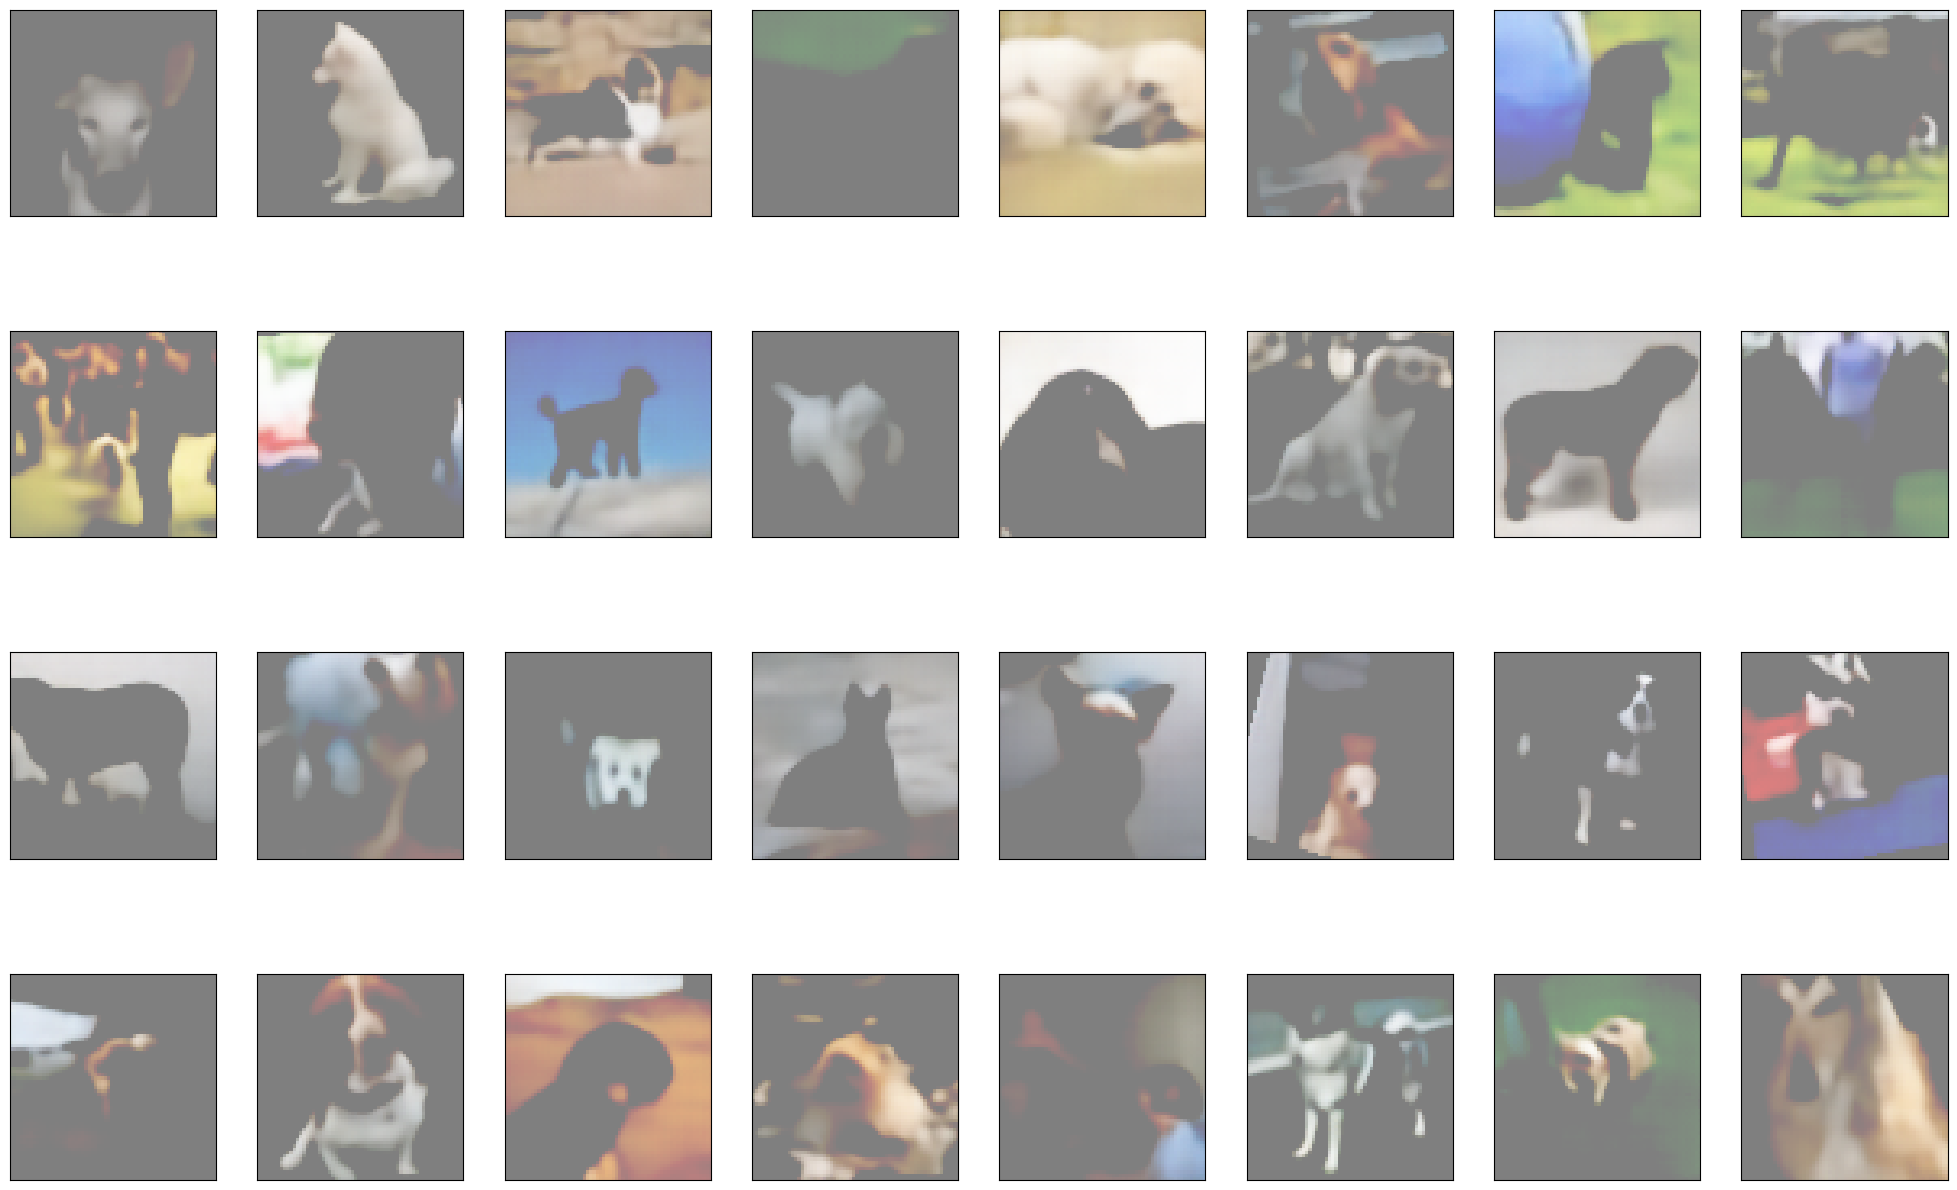

In [8]:
model.eval()
reconstructed, mu, _ = model(torch.tensor(imgs.transpose(0, 3, 1, 2)).to(device))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed[:32]):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

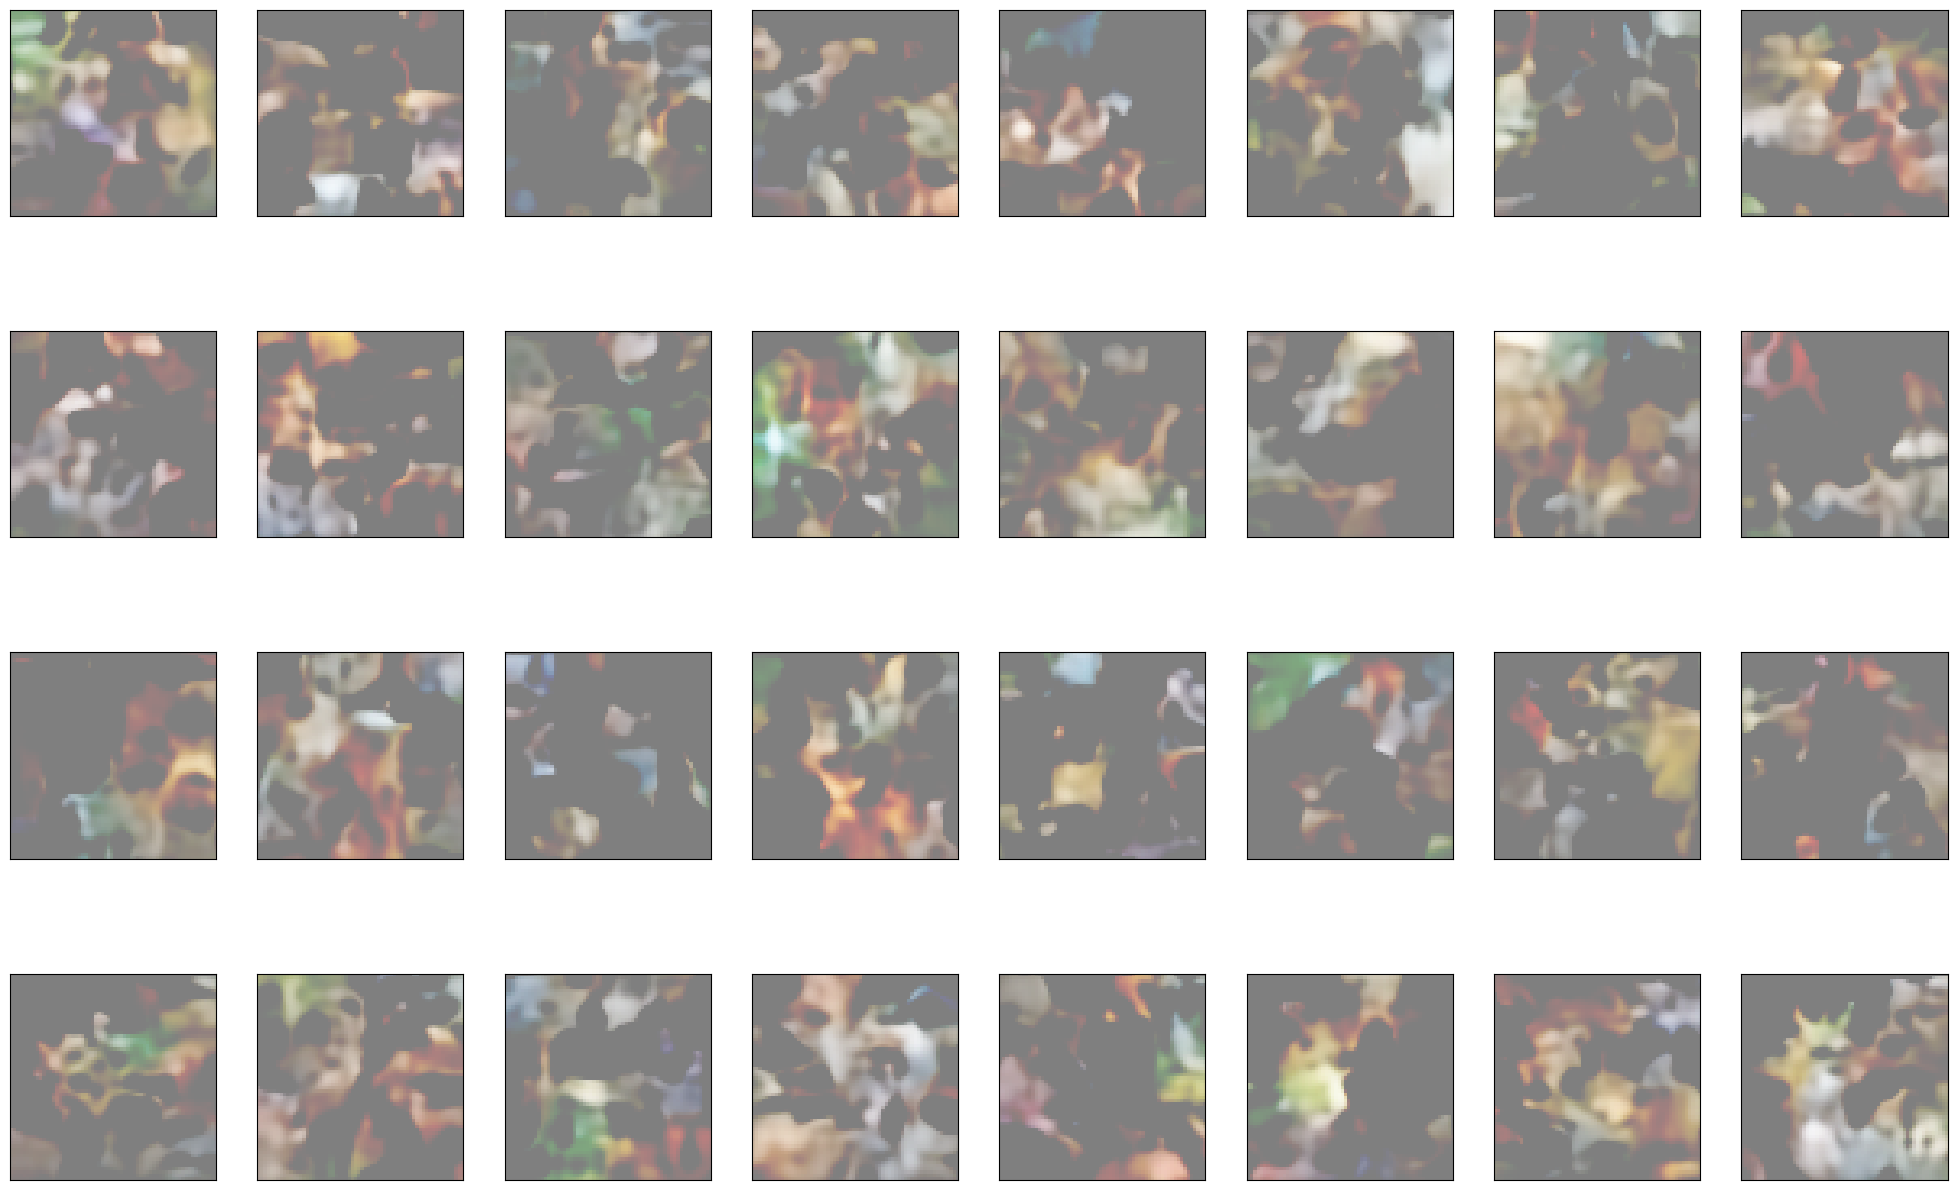

In [10]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

## Cropped images

In [16]:
lr = 1e-3
epochs = 20
latent_dim = 64

model = VAE(latent_dim, batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

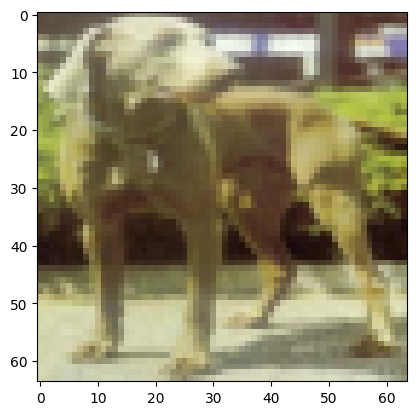

In [17]:
plt.imshow((imgs_cropped[0]+1)/2)
plt.show()

In [35]:
mse_losses, kld_losses = train(model, cropped_data_loader, optimizer, epochs, imgs_cropped)

Starting epoch: 1
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])
10 torch.Size([256, 3, 64, 64])



KeyboardInterrupt



Starting epoch: 1
Loss: Total: 245.46881103515625, MSE: 242.3356170654297, KLD: 3.133195638656616
Time for epoch 1: 93.73303651809692


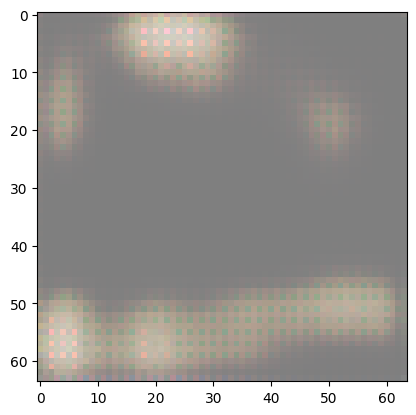

Starting epoch: 2
Loss: Total: 196.4119873046875, MSE: 194.20907592773438, KLD: 2.2029151916503906
Time for epoch 2: 71.18541669845581


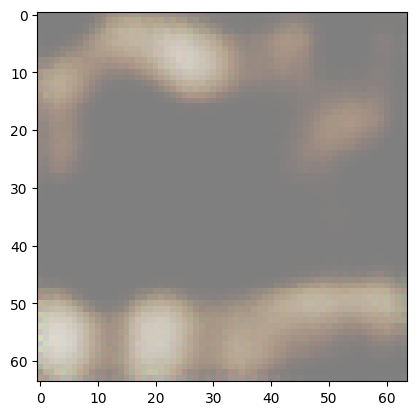

Starting epoch: 3
Loss: Total: 188.86090087890625, MSE: 186.5726318359375, KLD: 2.2882633209228516
Time for epoch 3: 68.4027509689331


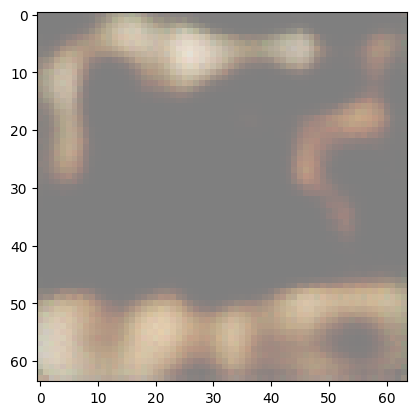

Starting epoch: 4
Loss: Total: 183.73574829101562, MSE: 181.32408142089844, KLD: 2.4116721153259277
Time for epoch 4: 84.4516191482544


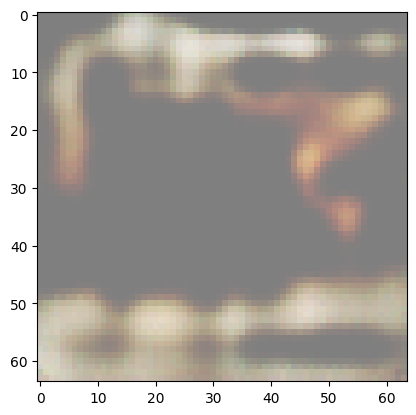

Starting epoch: 5
Loss: Total: 181.92947387695312, MSE: 179.46875, KLD: 2.460724353790283
Time for epoch 5: 59.755412340164185


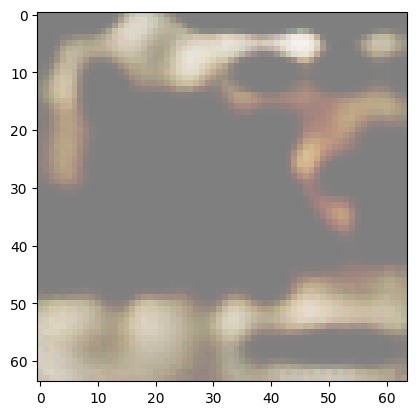

Starting epoch: 6
Loss: Total: 180.72923278808594, MSE: 178.2547149658203, KLD: 2.474517345428467
Time for epoch 6: 60.34541153907776


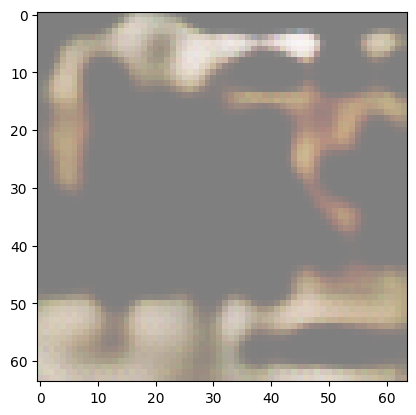

Starting epoch: 7
Loss: Total: 179.74911499023438, MSE: 177.26052856445312, KLD: 2.4885828495025635
Time for epoch 7: 61.56371855735779


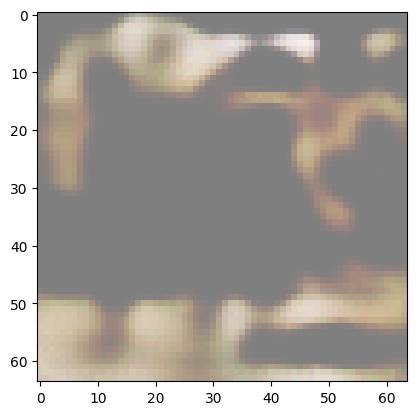

Starting epoch: 8
Loss: Total: 179.48593139648438, MSE: 176.98504638671875, KLD: 2.5008907318115234
Time for epoch 8: 66.5480694770813


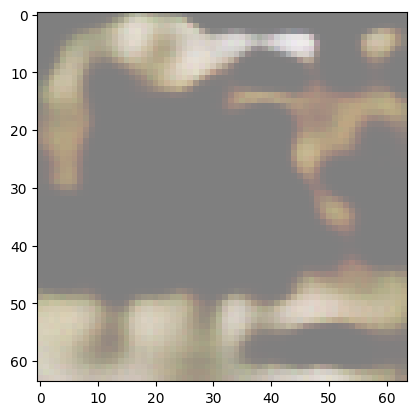

Starting epoch: 9
Loss: Total: 178.6951141357422, MSE: 176.18618774414062, KLD: 2.5089271068573
Time for epoch 9: 80.22592520713806


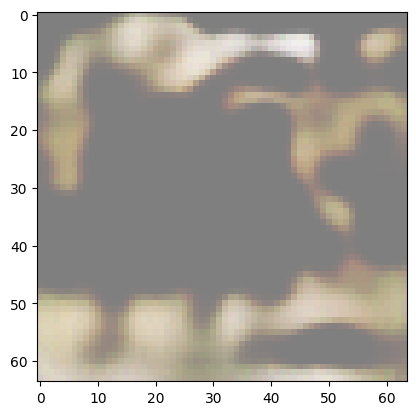

Starting epoch: 10
Loss: Total: 178.01437377929688, MSE: 175.4745330810547, KLD: 2.539846181869507
Time for epoch 10: 76.27015686035156


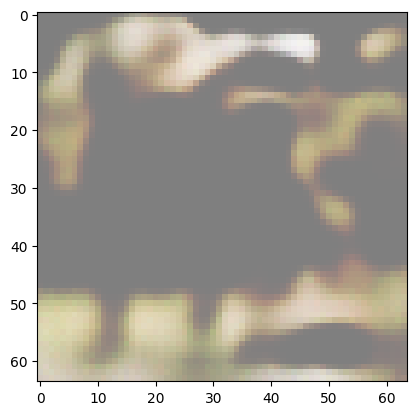

Starting epoch: 11
Loss: Total: 177.70420837402344, MSE: 175.1272735595703, KLD: 2.5769288539886475
Time for epoch 11: 66.6011106967926


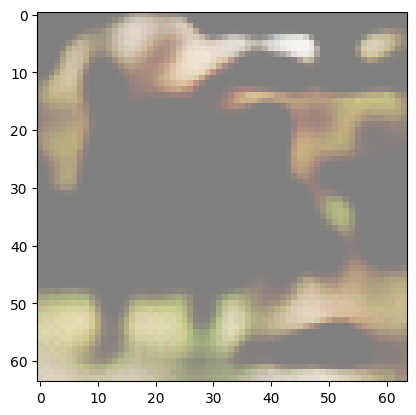

Starting epoch: 12
Loss: Total: 177.31175231933594, MSE: 174.7024688720703, KLD: 2.609286069869995
Time for epoch 12: 62.828972578048706


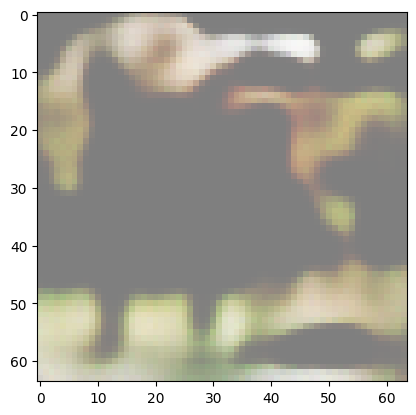

Starting epoch: 13
Loss: Total: 177.3037872314453, MSE: 174.6735382080078, KLD: 2.630248546600342
Time for epoch 13: 64.9341242313385


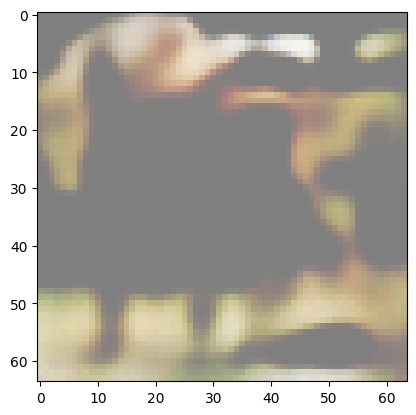

Starting epoch: 14
Loss: Total: 176.63589477539062, MSE: 173.999755859375, KLD: 2.6361348628997803
Time for epoch 14: 63.24139952659607


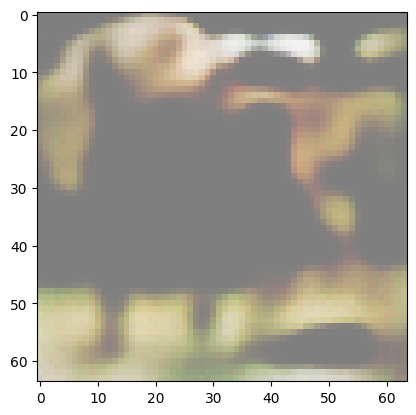

Starting epoch: 15
Loss: Total: 177.07447814941406, MSE: 174.42974853515625, KLD: 2.6447274684906006
Time for epoch 15: 65.53260087966919


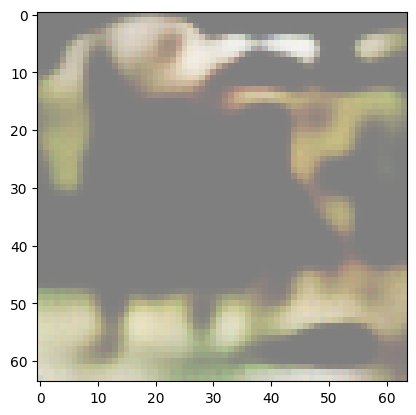

Starting epoch: 16
Loss: Total: 176.66102600097656, MSE: 174.0088653564453, KLD: 2.6521623134613037
Time for epoch 16: 64.89153575897217


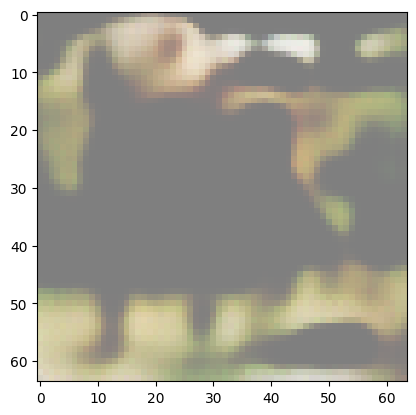

Starting epoch: 17
Loss: Total: 176.69265747070312, MSE: 174.0453643798828, KLD: 2.647289514541626
Time for epoch 17: 137.37783694267273


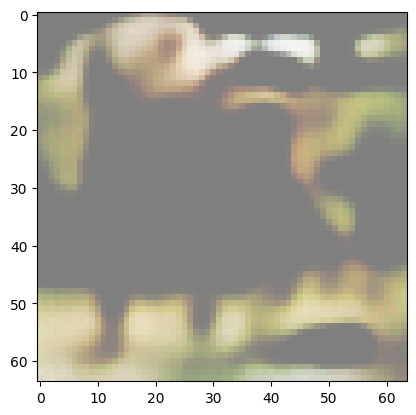

Starting epoch: 18
Loss: Total: 176.38519287109375, MSE: 173.72793579101562, KLD: 2.657264232635498
Time for epoch 18: 70.7599527835846


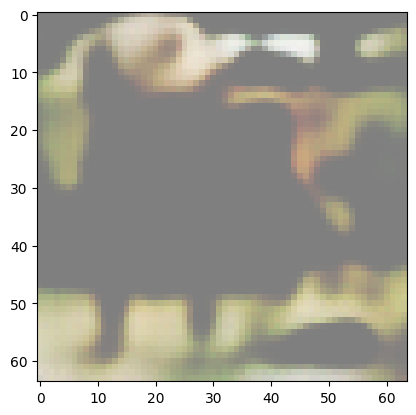

Starting epoch: 19
Loss: Total: 176.35325622558594, MSE: 173.68960571289062, KLD: 2.663651943206787
Time for epoch 19: 65.72129344940186


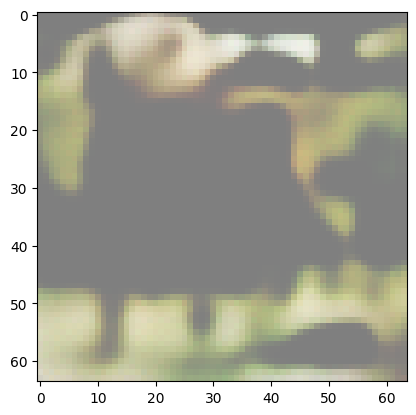

Starting epoch: 20
Loss: Total: 176.37744140625, MSE: 173.70687866210938, KLD: 2.6705660820007324
Time for epoch 20: 63.64935755729675


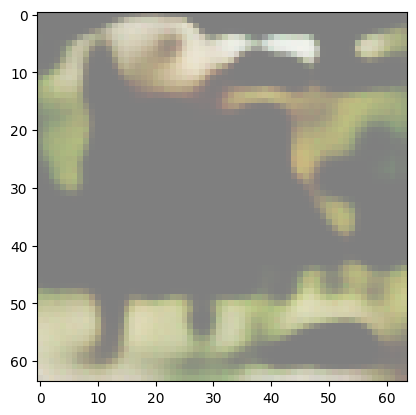

In [18]:
mse_losses, kld_losses = train(model, cropped_data_loader, optimizer, epochs, imgs_cropped)

In [19]:
mse_losses = torch.tensor(mse_losses, device = 'cpu').numpy()
kld_losses = torch.tensor(kld_losses, device = 'cpu').numpy()

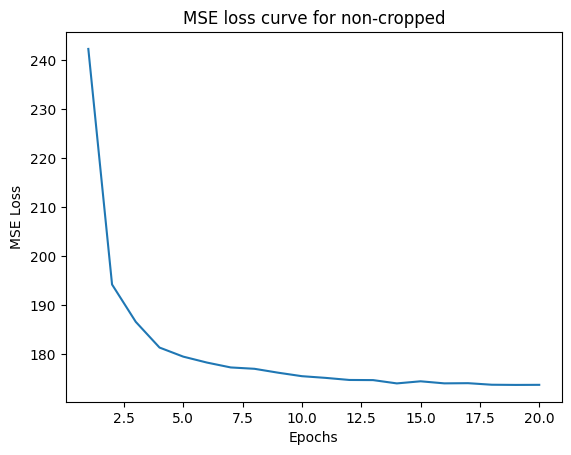

In [20]:
plt.plot(list(range(1, len(mse_losses)+1)), mse_losses)
plt.title('MSE loss curve for non-cropped')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

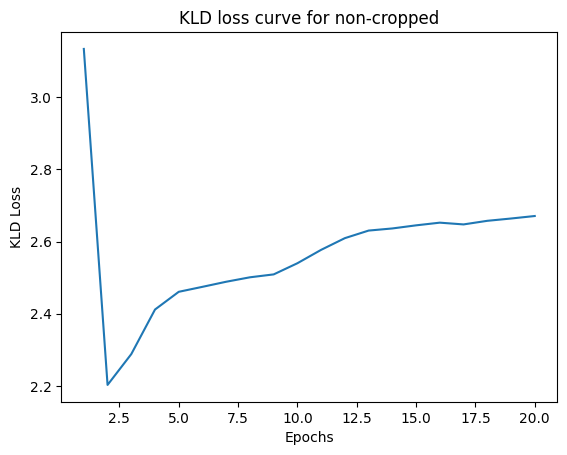

In [21]:
plt.plot(list(range(1, len(kld_losses)+1)), kld_losses)
plt.title('KLD loss curve for non-cropped')
plt.xlabel('Epochs')
plt.ylabel('KLD Loss')
plt.show()

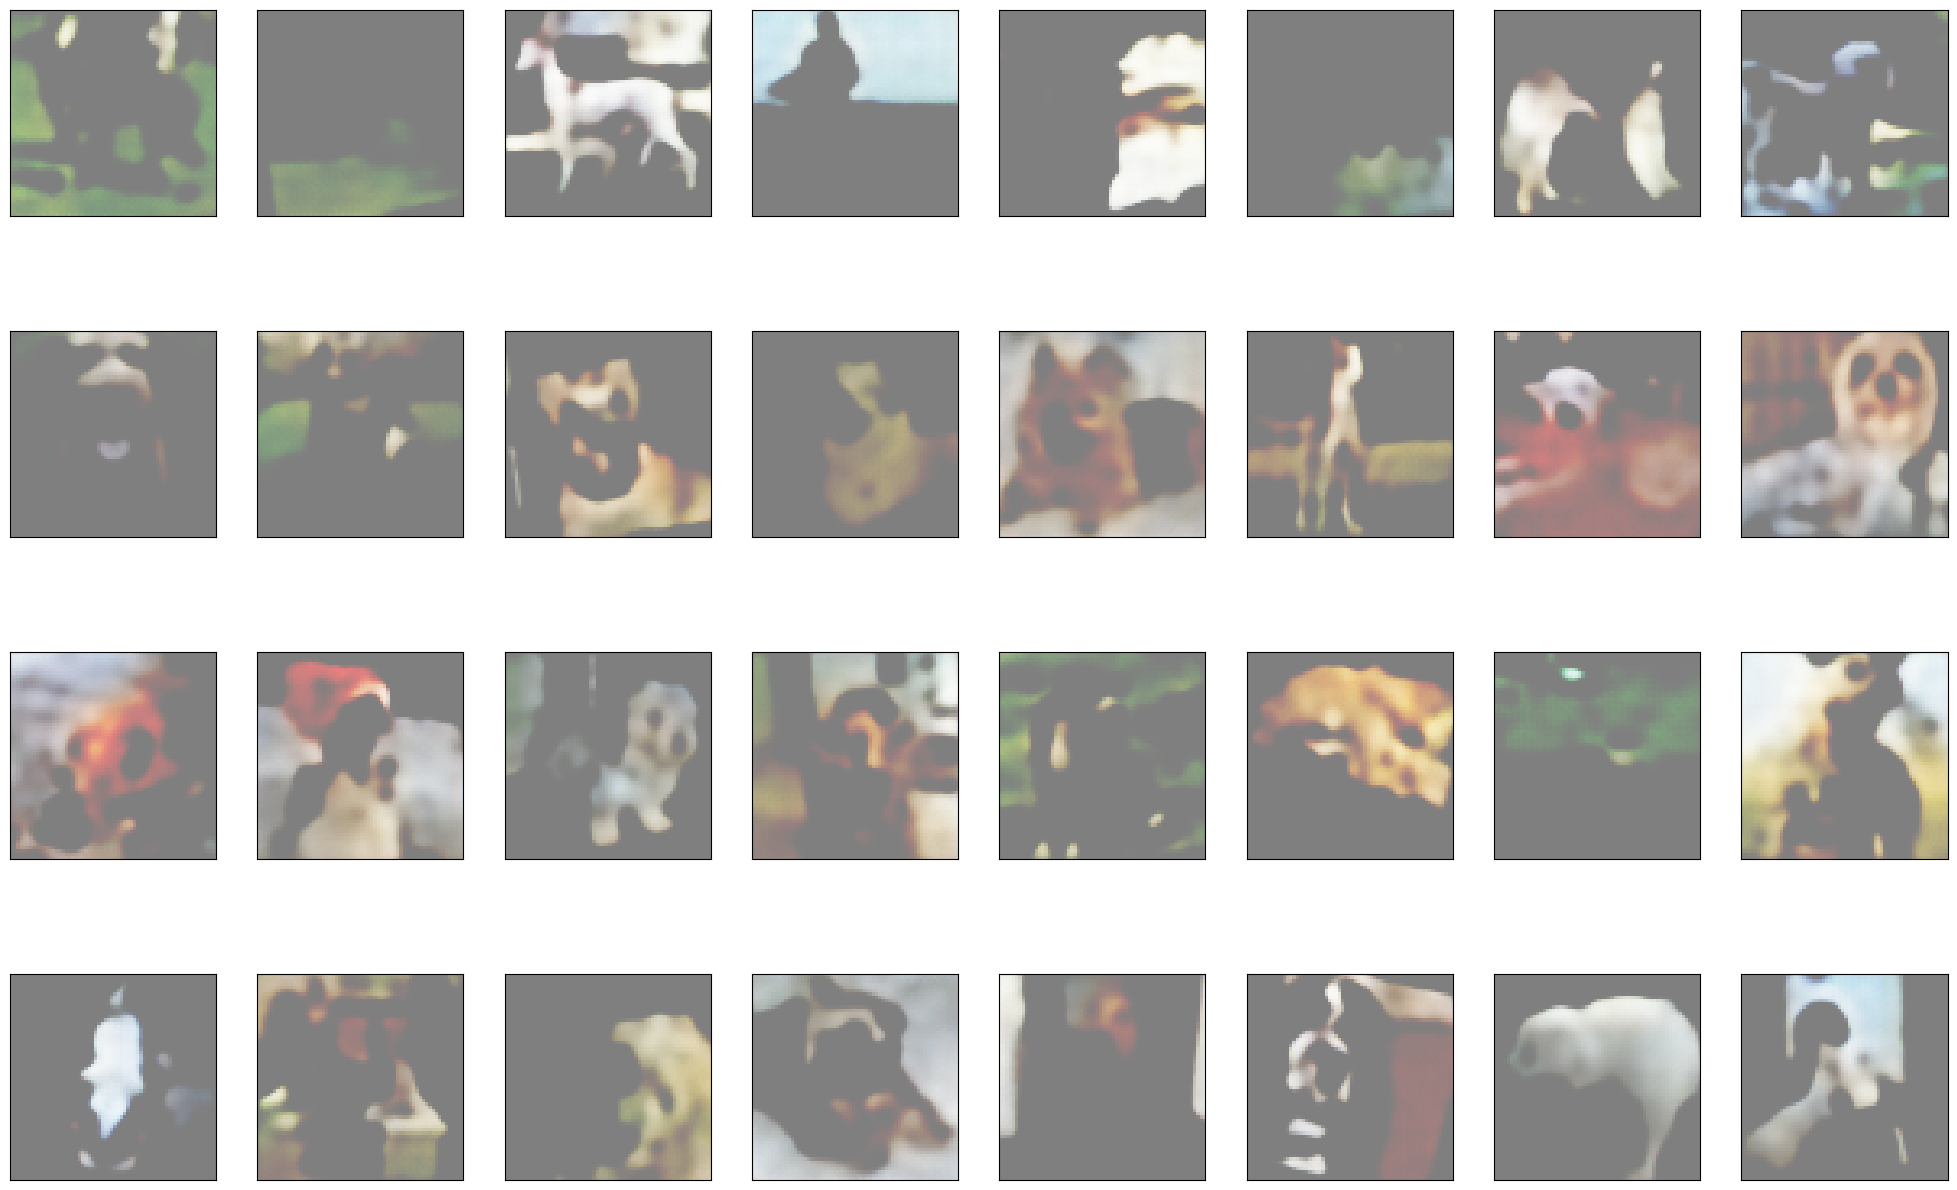

In [23]:
model.eval()
reconstructed, mu, _ = model(torch.tensor(imgs.transpose(0, 3, 1, 2)).to(device))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed[:32]):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

(32, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


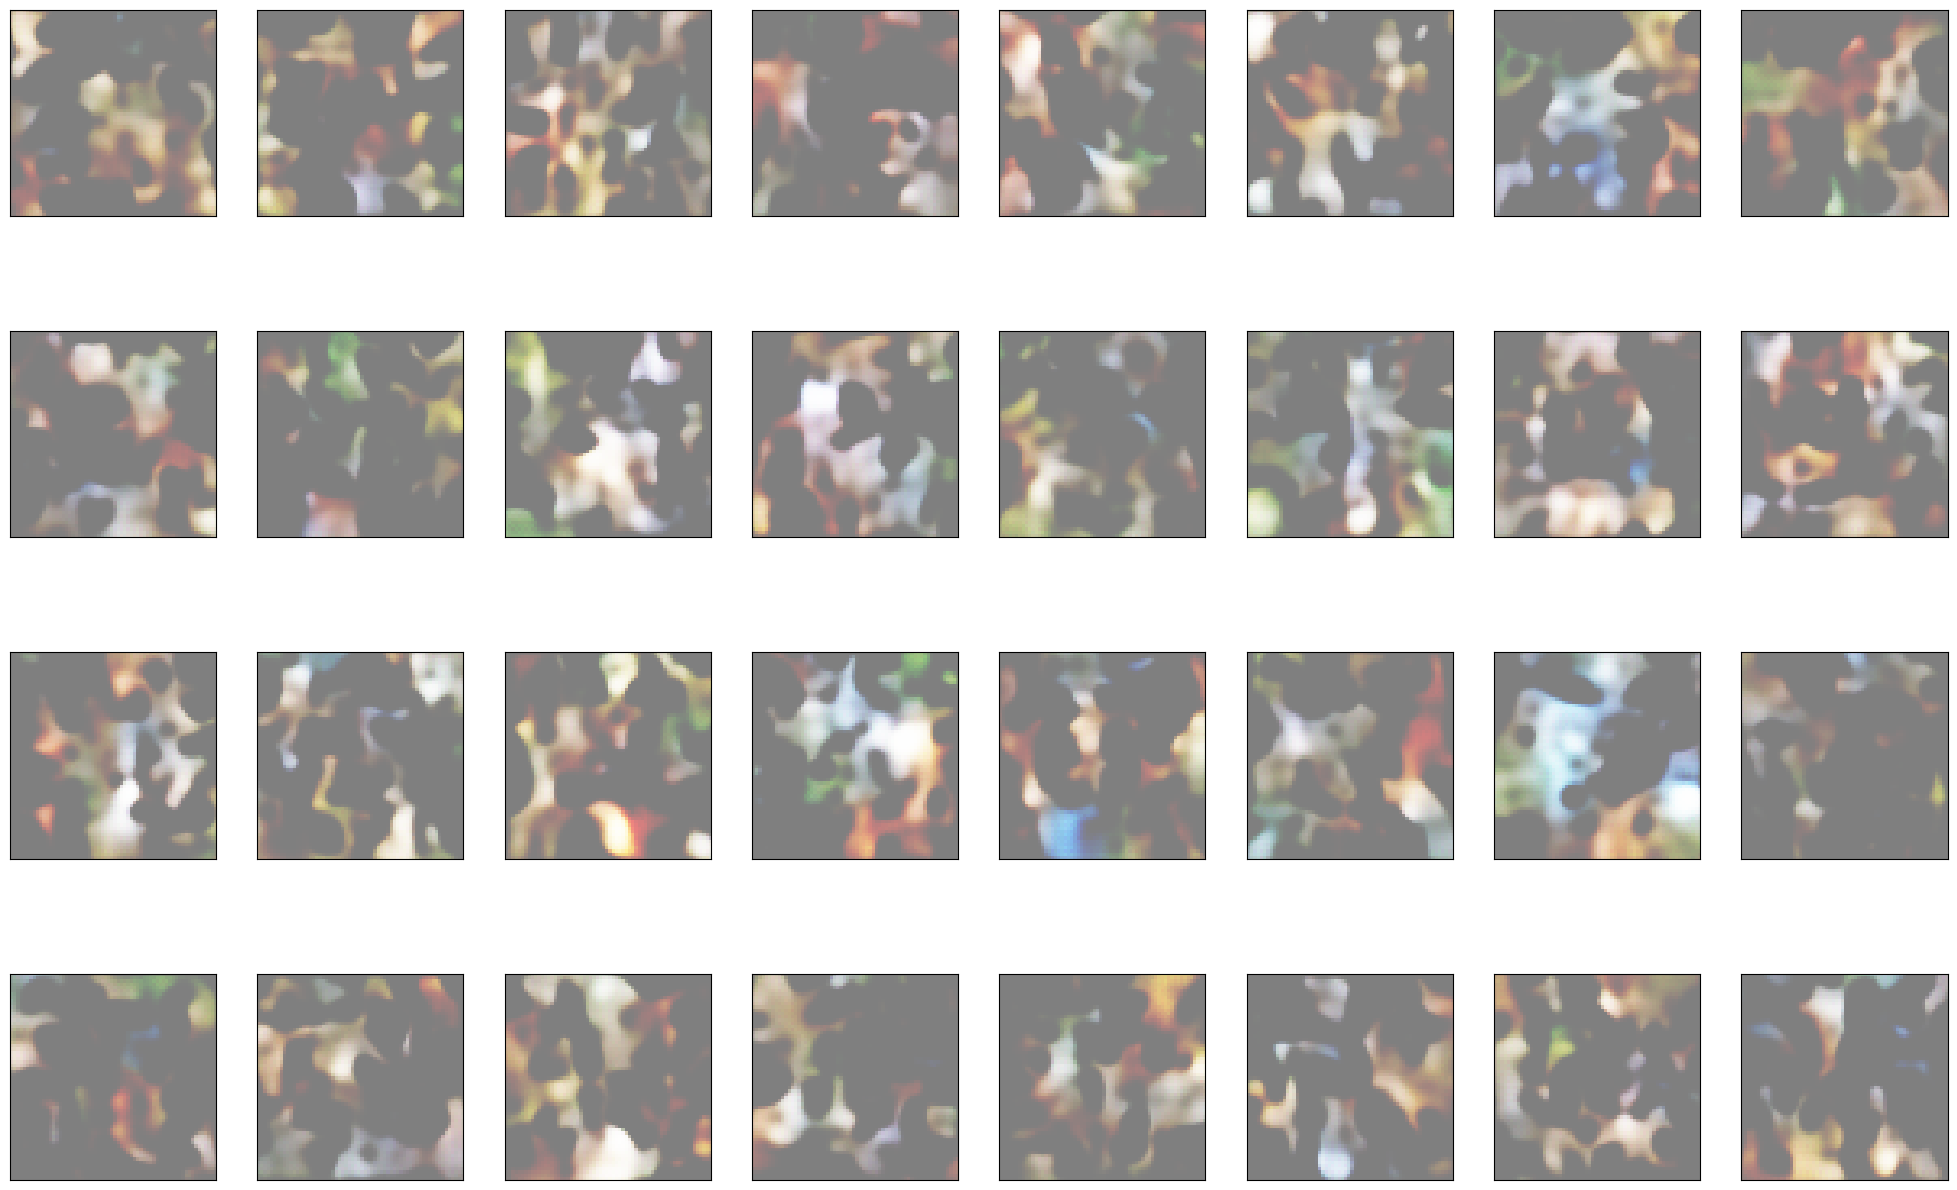

In [38]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

print(samples.shape)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):    
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)